# Details of the `beam_size()` Algorithm

**Scott Prahl**

**Mar 2021**

The ISO 11146 standard recommends masking the image with a rotated rectangular mask around the center of the image.  This notebook explains how that was implemented and then shows some results for artifically generated images of non-circular Gaussian beams. As noise increases, the first-order parameters (beam center) are robust, but the second-order parameters (diameters) are shown to be much more sensitive to image noise.

---
*If* `` laserbeamsize `` *is not installed, uncomment the following cell (i.e., delete the initial #) and execute it with* `` shift-enter ``.  *Afterwards, you may need to restart the kernel/runtime before the module will import successfully.*

In [1]:
#!pip install --user laserbeamsize

In [2]:
import imageio
import numpy as np
import matplotlib.pyplot as plt

try:
    import laserbeamsize as lbs

except ModuleNotFoundError:
    print('laserbeamsize is not installed. To install, uncomment and run the cell above.')
    print('Once installation is successful, rerun this cell again.')
    
repo = "https://github.com/scottprahl/laserbeamsize/raw/master/docs/"

In [3]:
def side_by_side_plot(h,v,xc,yc,dx,dy,phi,noise=0,offset=0):
    test = lbs.beam_test_image(h,v,xc,yc,dx,dy,phi,noise=noise)
    xc_found, yc_found, dx_found, dy_found, phi_found = lbs.beam_size(test)

    plt.subplots(1,2,figsize=(12,5))
    plt.subplot(1,2,1)
    plt.imshow(test,cmap='gist_ncar')
    plt.plot(xc,yc,'ob',markersize=2)
    plt.title('Original (%d,%d), dx=%.0f, dy=%.0f, $\phi$=%.0f°' % (xc,yc,dx,dy,np.degrees(phi)))

    plt.subplot(1,2,2)
    plt.imshow(test,cmap='gist_ncar')
    xp,yp = lbs.rotated_rect_arrays(xc_found, yc_found, dx_found, dy_found, phi_found)
    plt.plot(xp,yp,':y')
    plt.plot(xc_found,yc_found,'ob',markersize=2)
    plt.title('Found (%d,%d), dx=%.0f, dy=%.0f, $\phi$=%.0f°' % (xc_found,yc_found,dx_found,dy_found,np.degrees(phi_found)))

## Integration Area

ISO 11146-3 states::

> All integrations ... are performed on a rectangular integration area which is centred to the beam centroid, defined by the spatial first order moments, orientated parallel to the principal axes of the power density distribution, and sized three times the beam widths $d_{\sigma x}$ and $d_{\sigma y}$...

This turned out to be surprisingly fiddly (most likely because masked numpy arrays did't work as I expected).  In the pictures that follow, the dotted rectangle shows the final integration area.

## Algorithm Overview

This shows the effect of background removal, then rectangle masking, then locating the first 

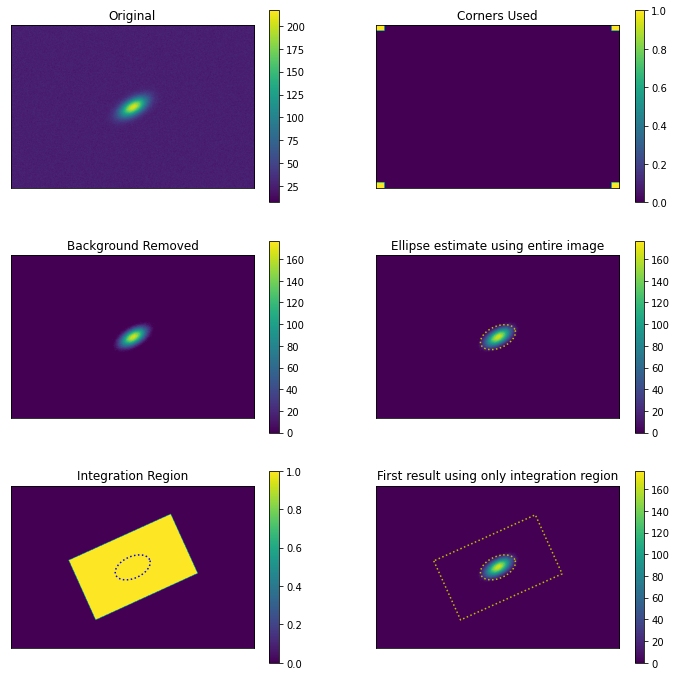

In [4]:
xc=300
yc=200
dx=100
dy=50
phi=np.radians(30)
h=600
v=400
max_value=1023
noise = 25

# generate test image
test = lbs.beam_test_image(h,v,xc,yc,dx,dy,phi,noise=noise)

plt.subplots(3,2,figsize=(12,12))
plt.subplot(3,2,1)
plt.imshow(test)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Original')

# corners
corners = lbs.corner_mask(test)
plt.subplot(3,2,2)
plt.imshow(corners)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Corners Used')

# remove background
back, sigma = lbs.corner_background(test)
offset = int(back+3*sigma)
zeroed = lbs.subtract_threshold(test, offset)

plt.subplot(3,2,3)
plt.imshow(zeroed)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Background Removed')

# first guess at beam parameters
xc, yc, dx, dy, phi = lbs.basic_beam_size(zeroed)

plt.subplot(3,2,4)
plt.imshow(zeroed)
plt.colorbar()
plt.xticks([])
plt.yticks([])
xp,yp = lbs.ellipse_arrays(xc, yc, dx, dy, phi)
plt.plot(xp,yp,':y')
plt.title('Ellipse estimate using entire image')

mask = lbs.rotated_rect_mask(zeroed, xc, yc, dx, dy, phi)

plt.subplot(3,2,5)
plt.imshow(mask)
plt.colorbar()
plt.xticks([])
plt.yticks([])
xp,yp = lbs.ellipse_arrays(xc, yc, dx, dy, phi)
plt.plot(xp,yp,':b')
plt.title('Integration Region')

masked_image = np.copy(zeroed)
masked_image[mask < 1] = 0       # zero all values outside mask

plt.subplot(3,2,6)
plt.imshow(masked_image)
plt.colorbar()
plt.xticks([])
plt.yticks([])
xp,yp = lbs.rotated_rect_arrays(xc, yc, dx, dy, phi)
plt.plot(xp,yp,':y')
xp,yp = lbs.ellipse_arrays(xc, yc, dx, dy, phi)
plt.plot(xp,yp,':y')
plt.title('First result using only integration region')

plt.show()

## Integration Area Tests

### Test 1 Centered, Horizontal, away from edges

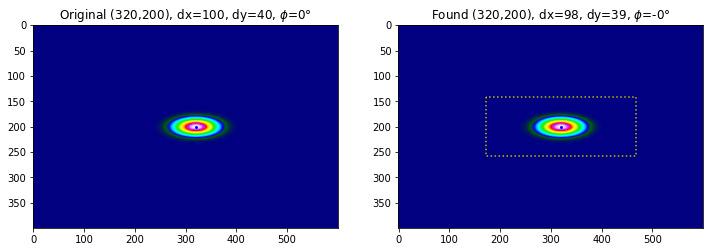

In [5]:
xc=320
yc=200
dx=100
dy=40
phi=np.radians(0)
h=600
v=400

side_by_side_plot(h,v,xc,yc,dx,dy,phi)
plt.show()

### Test 2 Corner, Horizontal

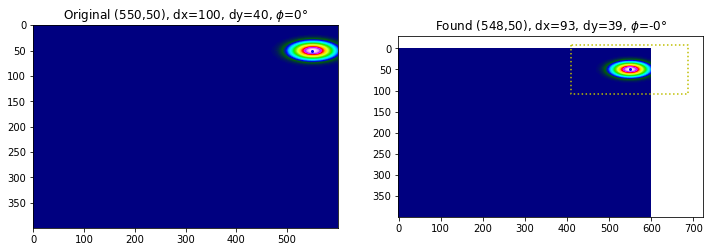

In [6]:
xc=550
yc=50

side_by_side_plot(h,v,xc,yc,dx,dy,phi)
plt.show()

### Test 3 Center, tilted 30°

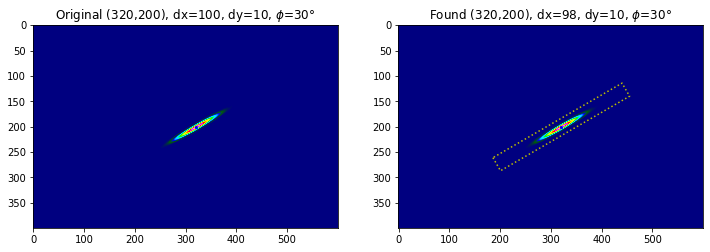

In [7]:
xc=320
yc=200
dx=100
dy=10
phi=np.radians(30)

side_by_side_plot(h,v,xc,yc,dx,dy,phi)
plt.show()

### Test 4 Corner, tilted 30°

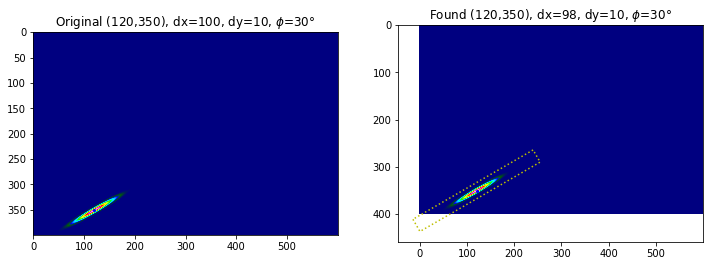

In [8]:
xc=120
yc=350

side_by_side_plot(h,v,xc,yc,dx,dy,phi)
plt.show()

### Test 5 Center, tilted 70°

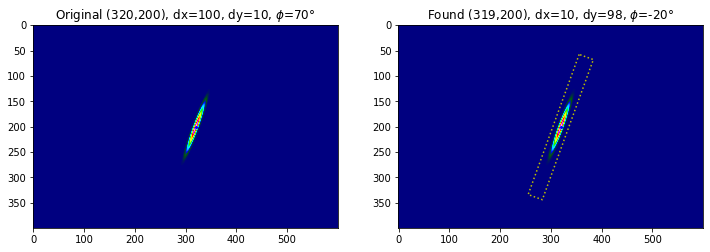

In [9]:
xc=320
yc=200
dx=100
dy=10
phi=np.radians(70)

side_by_side_plot(h,v,xc,yc,dx,dy,phi)
plt.show()

## Tests with Poisson noise

### Test 1. Simple, noise-free rotated elliptical beam

In this and all rest of the test functions, the maximum value in the test array is 256.

No gaussian noise, works fine!

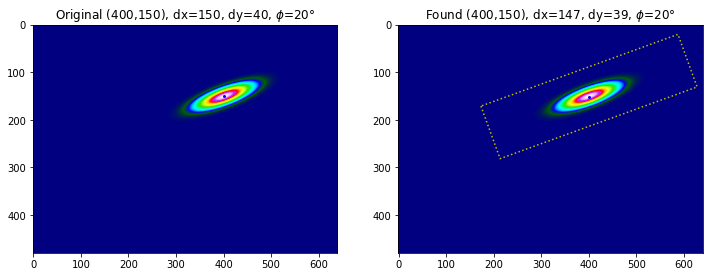

In [10]:
xc=400
yc=150
dx=150
dy=40
phi=np.radians(20)
h=640
v=480

side_by_side_plot(h,v,xc,yc,dx,dy,phi,noise=0)
plt.show()

### Test 2: Rotated elliptical beam with 4% Poisson noise

Here the added noise is enough to significantly affect the estimate of beam widths

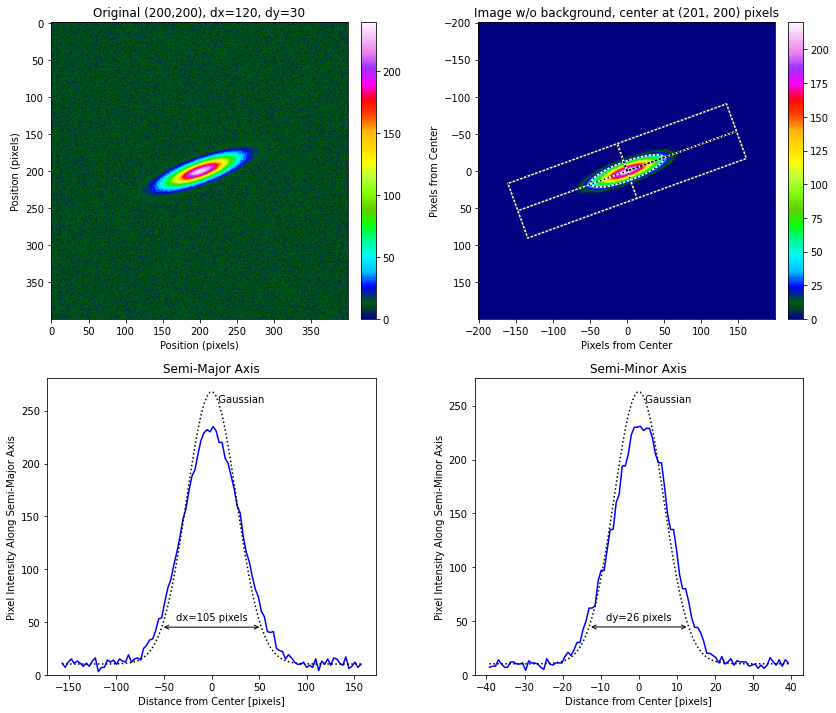

In [11]:
xc=200
yc=200
dx=120
dy=30
phi=np.radians(20)
h=400
v=400
max_value = 255
noise = 0.04 * max_value

test = lbs.beam_test_image(h, v, xc, yc, dx, dy, phi, noise=noise, max_value=max_value)
title = 'Original (%d,%d), dx=%d, dy=%d' % (xc,yc,dx,dy)

lbs.beam_size_plot(test, title)
#plt.savefig('plot2.pdf', bbox_inches = 'tight')
plt.show()

### Test 3: Experimental Image

This is a HeNe beam from a polarized HeNe which should be close to TEM00.

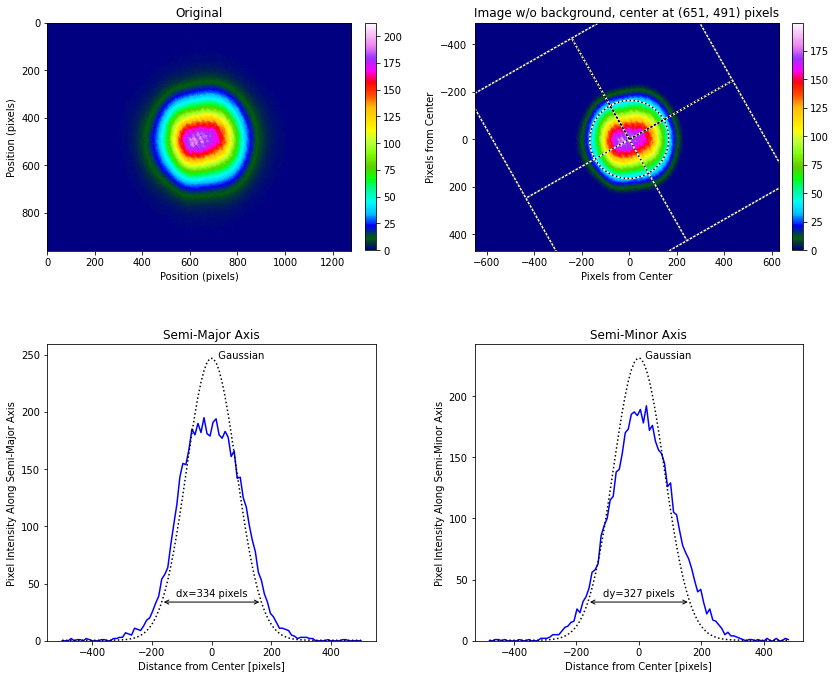

In [12]:
beam = imageio.imread(repo + "t-hene.pgm")
lbs.beam_size_plot(beam)
#plt.savefig('hene.png', bbox_inches = 'tight')
plt.show()

### Test 4: Asymmetric Experimental Image

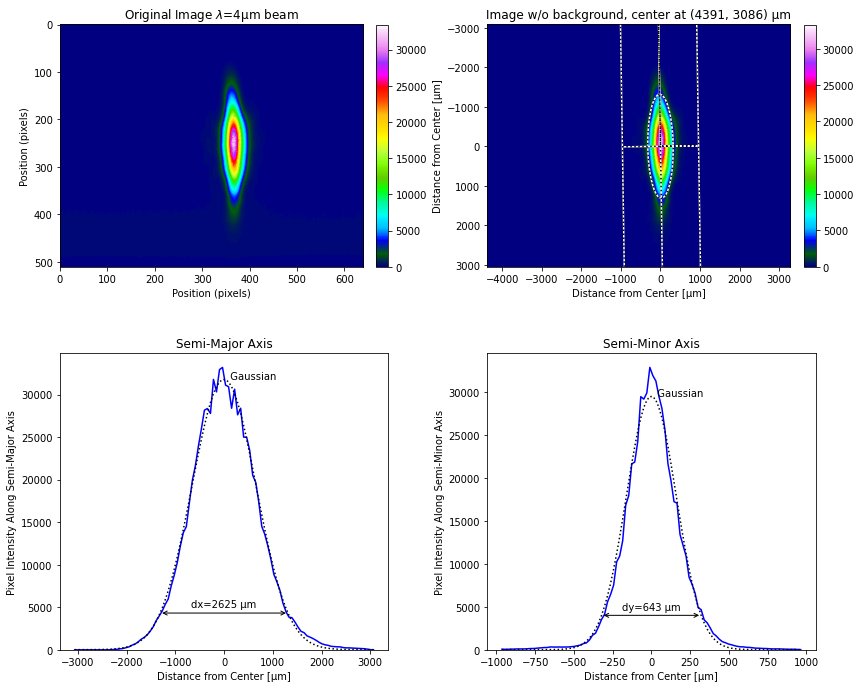

In [13]:
# Image contributed by Werefkin
# Created using an f=750 mm spherical mirror for focusing under 45 degrees incidence 
# The pixel size is 12 µm, wavelength is 4 µm (actually it is a polychromatic beam)

beam = np.load("astigmatic_beam_profile.npy")
lbs.beam_size_plot(beam, r"Original Image $\lambda$=4µm beam", pixel_size = 12, units='µm')
#plt.savefig('astigmatic_beam_profile.png', bbox_inches = 'tight')
plt.show()

### Test 5: Verify that `beam_size_plot()` properly identifies major axis

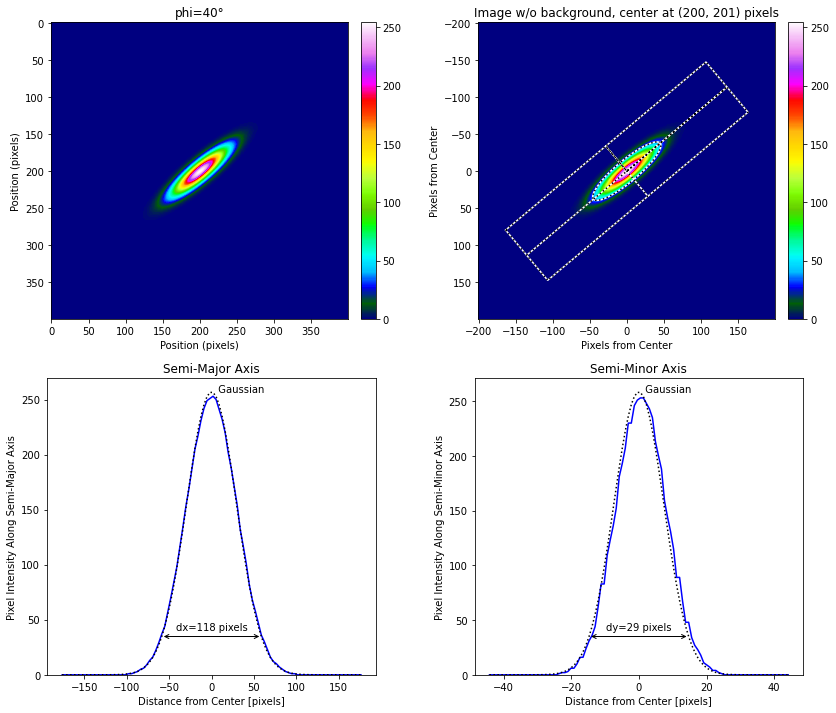

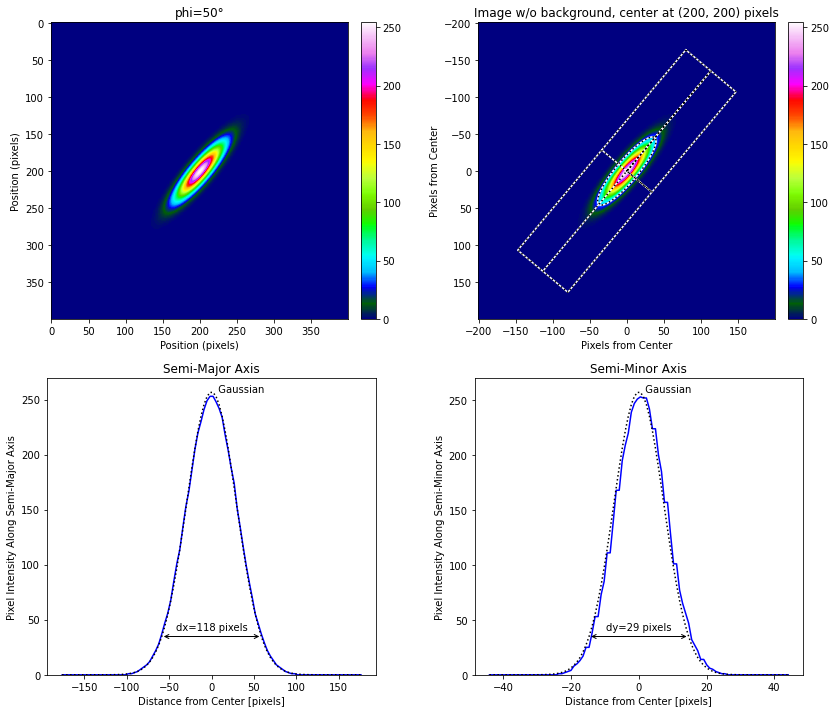

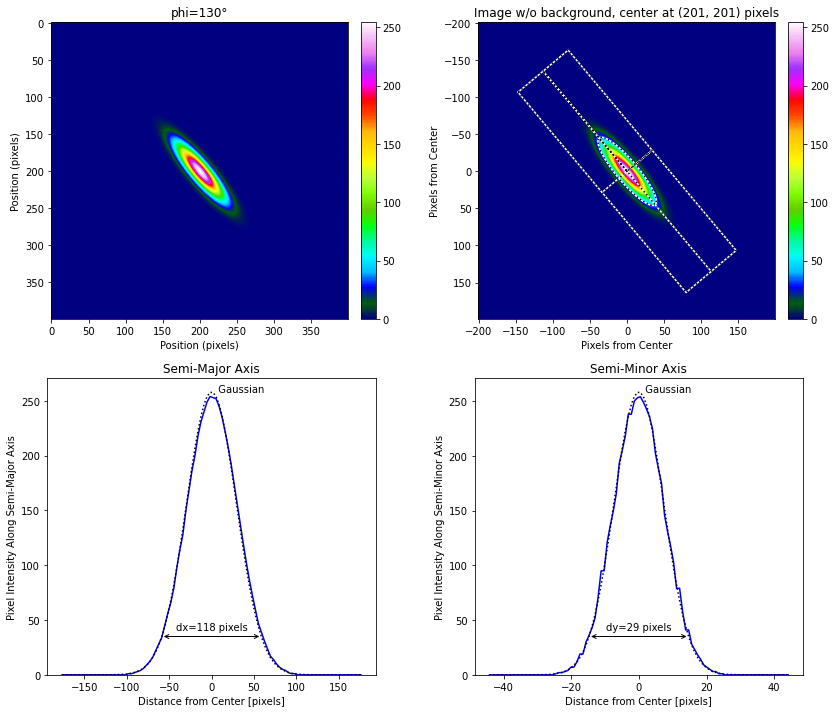

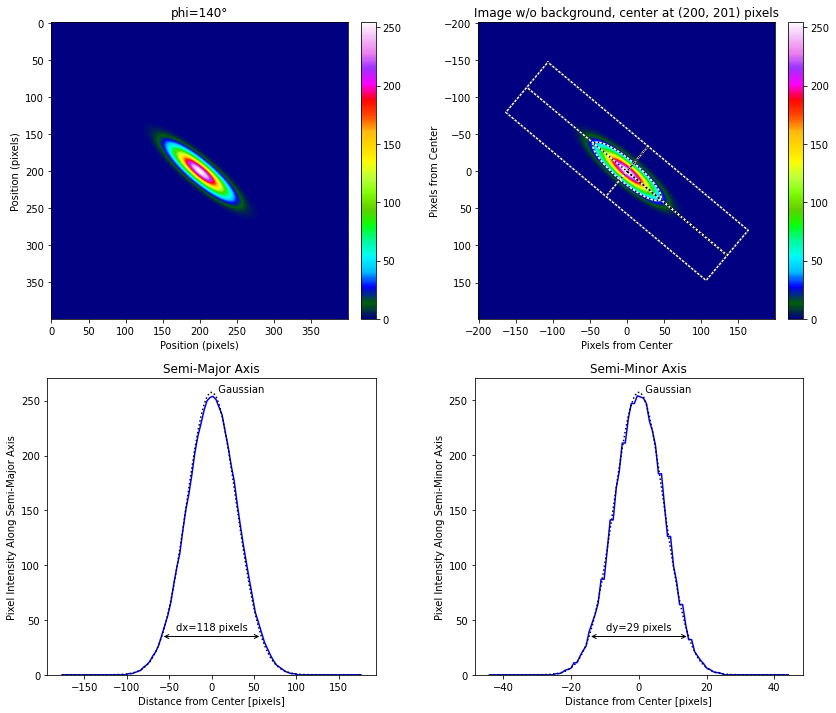

In [14]:
xc=200
yc=200
dx=120
dy=30
h=400
v=400
max_value = 255
noise = 0.04 * max_value

# major axis changes at 45 and 135 degrees.  test on each side
for phi_degrees in [40, 50, 130, 140]:
    phi = np.radians(phi_degrees)
    test = lbs.beam_test_image(h, v, xc, yc, dx, dy, phi, max_value=max_value)
    title = 'phi=%d°' % (phi_degrees)
    lbs.beam_size_plot(test, title)
    plt.show()
    print("\n\n\n\n\n")